In [3]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
import ProgressMeter
using CSV
using DataFrames

In [7]:
import ReactiveMP.messageout

In [6]:
include("../helpers/polynomial.jl")

ϕ (generic function with 2 methods)

In [8]:
### find order
delay_y, delay_u, delay_e = 3, 3, 3
poly_order = 2
order_h = delay_e + 1

output__ = ϕ(randn(sum([delay_u, delay_y, order_h])), Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>true, "crossTerms"=>true, "noiseCrossTerms"=>false))
full_order = length(output__)

42

In [9]:
ϕ(randn(sum([delay_u, delay_y, order_h])), Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>true, "crossTerms"=>true, "noiseCrossTerms"=>false))

42-element Vector{Float64}:
  1.0
 -2.2947975725540615
  5.266095899000013
  0.5376454293123988
 -1.233787426080879
  0.2890626076605136
 -0.43792089510791604
  1.0049398070643476
 -0.2354461676551655
  0.1917747103721184
  0.8904890212026945
 -2.0434920442419853
  0.47876735210250043
  ⋮
  0.16642635203739103
 -0.13555695460290354
  0.27564791077578255
 -0.26995561095346654
  0.33154188792551176
  0.09581914062369114
  0.7486903423617427
  0.5605372287457435
 -0.7521446025207352
  0.5657215031010748
 -0.14736470436200053
  0.021716356091699817

In [11]:
# output_ = ϕ([1.0, 2.0, 2.0, 1.0], Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>true, "crossTerms"=>true, "noiseCrossTerms"=>false))


In [12]:

function phi()
    options = Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>true, "crossTerms"=>true, "noiseCrossTerms"=>false)
    
    precompiled = precompiled_phi(options)
    
    return (u, y, h) -> begin
        na = length(y)
        nb = length(u)-1
        ne = length(h)-1
        precompiled([u; y; h[2:end]])
    end 
end

const phi_ = phi()

#3 (generic function with 1 method)

In [13]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function narmax(n, h_prior, w_prior, η_prior, τ_prior, y_prev, u, h_order, full_order, seed)
    obs_prec = 1e12  # softening plus
    
    # initialize variables
    θ  = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(h_order), obs_prec*diageye(h_order)))}
    w  = randomvar()
#     h  = randomvar(n) where { prod_constraint = ProdGeneric(), form_constraint = SampleListFormConstraint(nsamples, LeftProposal())}
#     z  = randomvar(n) where { prod_constraint = ProdGeneric(), form_constraint = SampleListFormConstraint(nsamples, RightProposal())}
    h  = randomvar(n)
    z  = randomvar(n)
    ẑ  = randomvar(n)
    y  = datavar(Float64, n)

    y_nodes = Vector{FactorNode}(undef, n)

    
    AR_meta_1 = ARMeta(Multivariate, h_order, ARsafe())
    AR_meta_2 = ARMeta(Multivariate, full_order, ARsafe())
    
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2]) where {q=MeanField()}
    w   ~ GammaShapeRate(w_prior[1], w_prior[2])
    θ   ~ MvNormalMeanPrecision(zeros(h_order), diageye(h_order))
    
    η   ~ MvNormalMeanPrecision(η_prior[1], η_prior[2])
    τ   ~ GammaShapeRate(τ_prior[1], τ_prior[2])
    
    b = zeros(full_order); b[1] = 1.0;
    c = zeros(h_order); c[1] = 1.0;
    
    h_prev = h_0
    for t in 1:n
        
        h[t] ~ AR(h_prev, θ, w) where {q = q(y,x)q(γ)q(θ), meta = AR_meta_1}
        z[t] ~ NonlinearNode(h[t]) where {pipeline=RequireInbound(in=MvNormalMeanPrecision(zeros(h_order), diageye(h_order))), meta = NonlinearMeta(phi_, y_prev[t], u[t], seed)}
        ẑ[t] ~ AR(z[t], η, τ) where {q = q(y)q(x)q(γ)q(θ), meta = AR_meta_2}
        
        y_nodes[t], y[t] ~ dot(ẑ[t], b) + dot(h[t], c)
        
        h_prev = h[t]
    end

    return θ, w, h, η, τ, z, ẑ, y_nodes, y
end

┌ Warning: `form_constraint` option is deprecated. Use `marginal_form_constraint` option for variable θ instead.
└ @ GraphPPL /Users/apodusenko/.julia/dev/GraphPPL/src/backends/reactivemp.jl:270


In [14]:
function narmax_inference(observations, observations_prev, controls; 
                          h_order, full_order,
                          h_prior=(randn(h_order), diageye(h_order)),
                          w_prior=(1.0, 1.0), 
                          η_prior=(zeros(full_order), diageye(full_order)),
                          τ_prior=(1.0, 1.0), vmp_its=10, seed=10, 
                          progress=true)
        
    n = length(observations)

    # define model
    model, (θ, w, h, η, τ, z, ẑ, y_nodes, y) = narmax(model_options(limit_stack_depth = 500),
                                                      n, h_prior, w_prior, η_prior, τ_prior, 
                                                      observations_prev, controls, h_order, full_order, seed)
    
    h_buffer = Vector{Marginal}(undef, n)
    z_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    
    θ_buffer = nothing
    w_buffer = nothing
    η_buffer = nothing
    τ_buffer = nothing
    
    subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    subscribe!(getmarginal(η), (x) -> η_buffer = x)
    subscribe!(getmarginal(w), (x) -> w_buffer = x)
    subscribe!(getmarginal(τ), (x) -> τ_buffer = x)
    
    subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    subscribe!(getmarginals(z), (x) -> copyto!(z_buffer, x))
    

    subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginals!(h, MvNormalMeanPrecision(zeros(h_order), diageye(h_order)))
    setmarginals!(z, MvNormalMeanPrecision(zeros(full_order), diageye(full_order)))
    setmarginals!(ẑ, MvNormalMeanPrecision(zeros(full_order), diageye(full_order)))
    setmarginal!(w, GammaShapeRate(w_prior[1], w_prior[2]))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(h_order), diageye(h_order)))
    setmarginal!(τ, GammaShapeRate(τ_prior[1], τ_prior[2]))
    setmarginal!(η, MvNormalMeanPrecision(η_prior[1], η_prior[2]))
    
    setmessages!(h, MvNormalMeanPrecision(zeros(h_order), 1e12diageye(h_order)))
    
    p = ProgressMeter.Progress(vmp_its)
    for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
        if progress
            ProgressMeter.next!(p)
        end
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, θ_buffer, w_buffer, η_buffer, τ_buffer, z_buffer, y_out_buffer
    
end

narmax_inference (generic function with 1 method)

In [15]:
function ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ssm (generic function with 1 method)

## cascade dataset

In [445]:
df = DataFrame(CSV.File("../datasets/cascadedtanks/dataBenchmark.csv"));
u_train, u_val, y_train, y_val = df[:,1], df[:,2], df[:,3], df[:,4]

# normalization
m_y, s_y = mean(y_train), std(y_train)
m_u, s_u = mean(u_train), std(u_train)
output_trn = (y_train .- m_y) ./ s_y
output_val = (y_val .- m_y) ./ s_y
input_trn = (u_train .- m_u) ./ s_u
input_val = (u_val .- m_u) ./ s_u;

# output_trn = y_train
# output_val = y_val
# input_trn = input_trn
# input_val = input_val

# output_trn = collect(Iterators.flatten([output_trn[1:10:end] for i in 1:10]))
# output_val = collect(Iterators.flatten([output_val[1:10:end] for i in 1:10]))
# input_trn = collect(Iterators.flatten([input_trn[1:10:end] for i in 1:10]))
# input_val = collect(Iterators.flatten([input_val[1:10:end] for i in 1:10]))

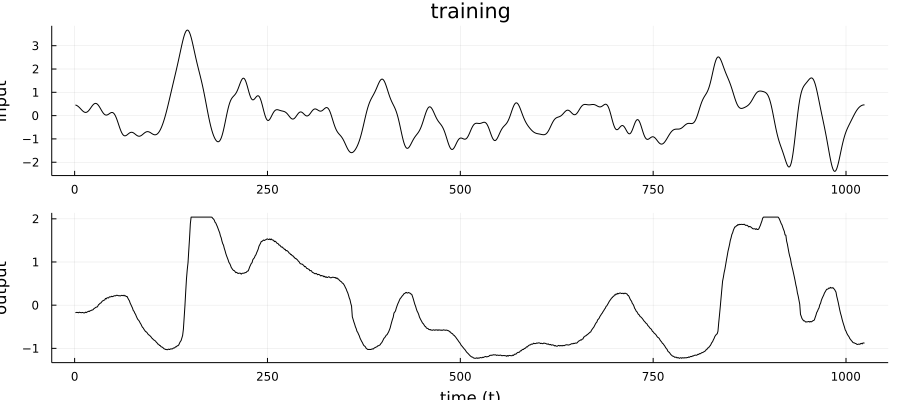

In [446]:
# Plot every n-th time-point to avoid figure size exploding
n = 1
ix = 1:n:length(output_trn)

# Plot training signals
p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

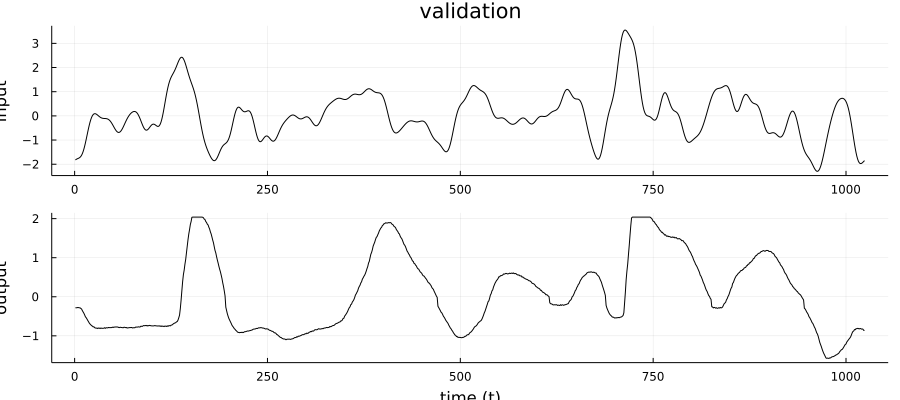

In [447]:
n = 1
ix = 1:n:length(output_val)

# Plot validation signals
p1a = plot(ix, input_val[ix], color="black", label="", xlabel="", ylabel="input", title="validation")    
p1b = plot(ix, output_val[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

## silverbox dataset

In [485]:

df = DataFrame(CSV.File("../datasets/silverbox/SNLS80mV.csv", ignoreemptylines=true))

# Select input and output signals
input = df[:,:V1]
output = df[:,:V2]

# Time horizon
T = length(input);

# normalization
input = (input .- mean(input))/std(input)
output = (output .- mean(output))/std(output);

In [486]:
# Select training set
trn = collect(40101:131072)
input_trn = input[trn]
output_trn = output[trn]
T_trn = length(trn);

# Select validation set
val = 101:40100
input_val = input[val]
output_val = output[val]
T_val = length(val);

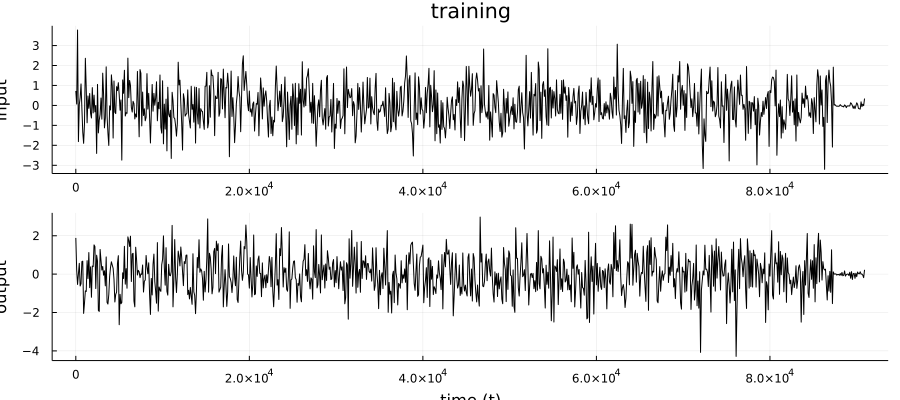

In [487]:
# Plot every n-th time-point to avoid figure size exploding
n = 100
ix = 1:n:T_trn

# Plot training signals
p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

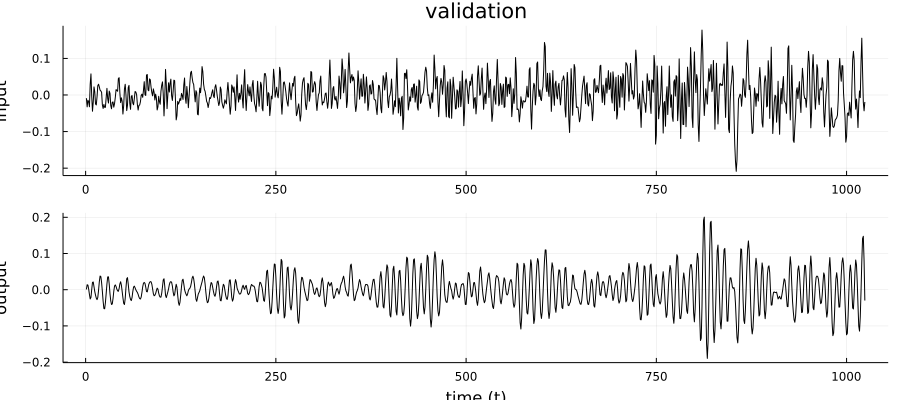

In [488]:
n = 1
ix = 1:n:1024

# Plot validation signals
p1a = plot(ix, input_val[ix], color="black", label="", xlabel="", ylabel="input", title="validation")    
p1b = plot(ix, output_val[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

### prepare training/test sets 

In [452]:
start = 1000
train_size = 1000
end
test_size = 1000
# train_size = 100
# test_size = 50

# Generate training data
observations_prev, observations = ssm(output_trn, delay_y)
controls = ssm(input_trn, delay_u+1)[1]
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size];

# Generate validation data
observations_prev, observations = ssm(output_val, delay_y)
controls = ssm(input_val, delay_u+1)[1]
X_test, Y_test, U_test = observations_prev[1:test_size], observations[1:test_size], controls[1:test_size];

In [453]:
include("../helpers/ar_extension.jl")

In [454]:
include("../helpers/nonlinear_node.jl")

In [455]:
# @unpack fe_, h_, w_, η_, τ_ = JLD.load("../dump/narmax_inferred_cascade_$(delay_y)_$(delay_u)_$(delay_e)_$(poly_order).jld");
# @unpack fe_, h_, w_, η_, τ_ = JLD.load("../dump/narmax_inferred_silverbox_$(delay_y)_$(delay_u)_$(delay_e)_$(poly_order).jld");

In [456]:
# coefs_mean = [-0.004552320266274442, -0.15497009685328844, -0.14819939430351792, -0.14133258803079096, 0.16769248059296432, 0.2906446706029808, 0.13602916782917376, -0.14247099912939865, 0.15335884771138897, -0.14793258232576895, 1.4654127804080395, -0.03476013803088124, -0.027686615634334916, 0.11188173029492743, -0.01143142541313763, 0.061642412910748734, 0.22972595387635564, 0.01215154565343135, -0.1452358480205993, -0.311351160888663, -0.46449444629292236, -0.008697907923367804, 0.06501199868537416, -0.06764421499629247, -0.06466000719265752, -0.026728331493522328, -0.40924695175884196, 0.125612738106754, 0.17643236023657383, 0.33556464558774346, 0.1841423703498597, -0.09425601125035854, -0.07234295338155405, 0.15909997497067518, -0.1865190941321544, -0.09347713742573616, -0.018817352855649006, 0.12999902924639173] 
realish = [-0.0005020087477669818, -0.19888245332633947, 0.2284249517358315, 0.9900635121105694, 0.4591040743595447]
realish = [0.0001249168565140039, -0.04797386559225805, 0.10644909220635754, 0.14494394608517608, -0.07033359635400402, -0.19548617037008342, -0.19093363531995966, -0.025089384031466766, -0.007246823265066871, 0.22042006763254307, 0.10579751167241397, 0.0070610023102248565, 0.03899391045834533, 0.1083325797048835, -0.1846091154376968, 1.3030247568532456, 0.0054218063394816385, 0.03412502482878502, 0.013645103093836208, 0.1330603015154983, 0.006014909102431076, 0.03423999592665006, -0.045945631941849974, -0.05285667336036065, -0.139347826346303, -0.07796822140554782, -0.06914991178286975, 0.038524063164130956, -0.342318223901521, 0.05863394784196757, 0.05400018411157917, -0.0072497656638840224, 0.028165362488370038, 0.04043266666784362, -0.044372249821302834, 0.027515960925668215, -0.0738710400313411, 0.1696638079888273, 0.026393698803404808, 0.10458393511059594, 0.062268038035810144, -0.06649470922612188]
# coefs_mean = realish
coefs_precision = 1e-2diageye(full_order)
# coefs_precision[end] = 1e10
# coefs_precision[1:8, 1:8] = 1e4*diageye(8)
# coefs_precision[9:35, 9:35] = 1e-1*diageye(27)
# coefs_precision[36:end, 36:end] = 1e6*diageye(7)
coefs_mean = zeros(full_order);


In [457]:
# # filtering

# h_prior = MvNormalMeanPrecision(zeros(order_h), 1e4diageye(order_h))
# η_prior = MvNormalMeanPrecision(coefs_mean, coefs_precision)
# w_prior = GammaShapeRate(1e4, 1.0)
# τ_prior = GammaShapeRate(1e2, 1.0)

# h_inferred = []

# ProgressMeter.@showprogress for i in 1:length(Y_train)
#     _, h_post, θ_post, w_post, η_post, τ_post, z_post, y_out_post = narmax_inference([Y_train[i]], [X_train[i]], [U_train[i]], h_order=order_h, full_order=full_order,
#                                                                                      h_prior=(mean(h_prior), precision(h_prior)),
#                                                                                      w_prior=(shape(w_prior), rate(w_prior)), 
#                                                                                      η_prior=(mean(η_prior), precision(η_prior)),
#                                                                                      τ_prior=(shape(τ_prior), rate(τ_prior)), vmp_its=10);
#     h_prior = h_post[end]
#     η_prior = η_post
#     τ_prior = τ_post
#     w_prior = w_post
    
#     push!(h_inferred, h_prior)
# end

In [458]:
# plot(first.(mean.(h_inferred)), ribbon=first.(std.(h_inferred)))

In [459]:
# plot(last.(mean.(h_inferred)), ribbon=last.(std.(h_inferred)))

In [460]:
# plot(mean(η_prior))

In [461]:
sampling_seed = 1
fe_, h_, θ_, w_, η_, τ_, z_, y_out_ = narmax_inference(Y_train, X_train, U_train, h_order=order_h, full_order=full_order,
                                                       h_prior=(zeros(order_h), diageye(order_h)),
                                                       w_prior=(1e5, 1.0), 
                                                       η_prior=(coefs_mean, coefs_precision),
                                                       τ_prior=(1e2, 1.0), vmp_its=50, seed=sampling_seed);



Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


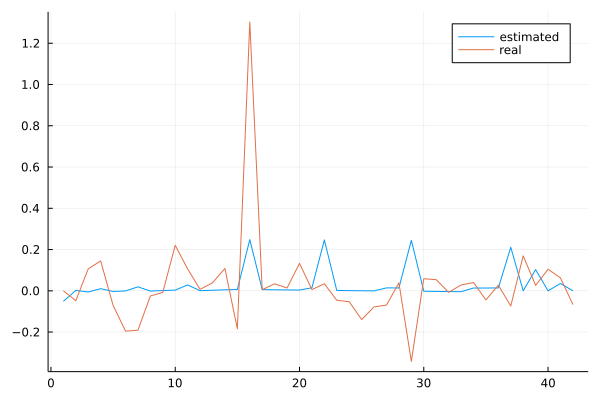

In [462]:
plot(mean(η_), label="estimated")
# plot!(coefs_mean, label="prior")
plot!(realish, label="real")

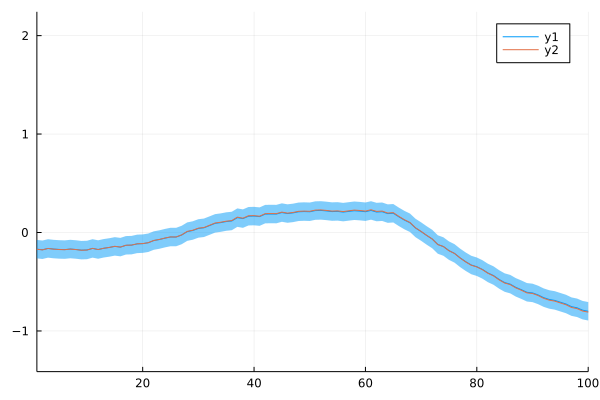

In [463]:
mfrom, mto = 1, 100
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(mfrom, mto))

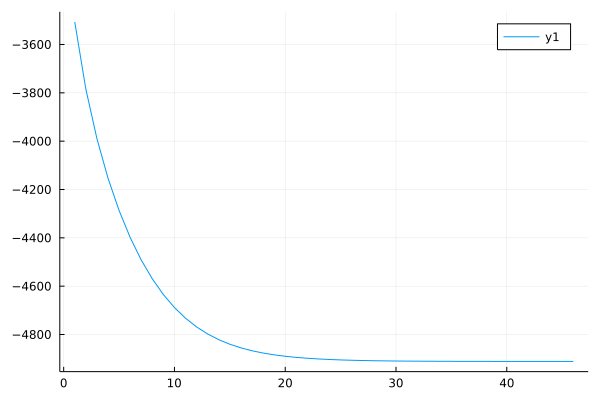

In [464]:
plot(fe_[5:end])

In [465]:
# JLD.save("../dump/narmax_inferred_cascade_$(delay_y)_$(delay_u)_$(delay_e)_$(poly_order).jld", "η_", η_, "τ_", τ_, "w_", w_, "h_", h_, "fe_", fe_)

In [466]:
mean(τ_)

113.84623572829143

In [467]:
mean(w_)

100000.3940995594

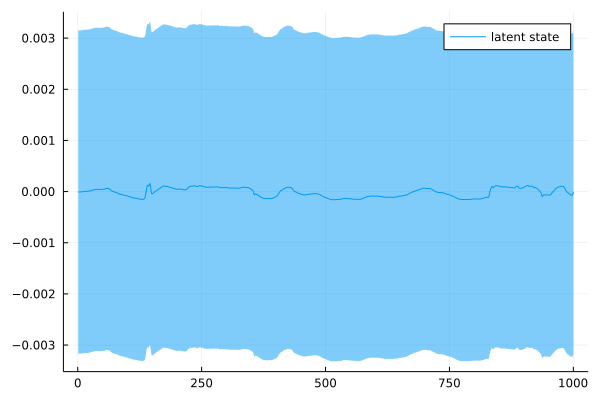

In [468]:
plot(first.(mean.(h_)), ribbon=sqrt.(first.(cov.(h_))), label="latent state")

## Prediction 

In [469]:
function transition(γ, order)
    V = zeros(order, order)
#     V = diageye(order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [470]:
function prediction(h_prior, w_mle, η_posterior, τ_posterior, y_prev, u; full_order, h_order)
    h_out = @call_rule MvNormalMeanCovariance(:out, Marginalisation) (m_μ=MvNormalMeanPrecision(mean(h_prior), precision(h_prior)), q_Σ=PointMass(transition(mean(w_), order_h)))
    ϕ_out = @call_rule NonlinearNode(:out, Marginalisation) (m_in=h_out, meta=NonlinearMeta(phi_, y_prev, u, full_order))
    ar_out = @call_rule AR(:y, Marginalisation) (m_x=ϕ_out, q_θ=η_posterior, q_γ=τ_posterior, meta=ARMeta(Multivariate, full_order, ARsafe()))
    c = zeros(full_order); c[1] = 1.0
    dot_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=ar_out, meta=ReactiveMP.TinyCorrection())
    c = zeros(h_order); c[1] = 1.0
    c_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=h_out, meta=ReactiveMP.TinyCorrection())
    @call_rule typeof(+)(:out, Marginalisation) (m_in1=dot_out, m_in2=c_out)    
end

prediction (generic function with 1 method)

In [471]:
τ_ = GammaShapeRate(shape(τ_), rate(τ_))

GammaShapeRate{Float64}(a=600.0, b=5.270266479710199)

In [472]:
predictions = []
h_prior = h_[end]
w_prior = w_
τ_prior = τ_
η_prior = η_

ProgressMeter.@showprogress for i in 1:length(Y_test)
    pred = prediction(h_prior, mean(w_), η_, τ_, X_test[i], U_test[i], full_order=full_order, h_order=order_h)
#     pred = mean(η_)'ϕ([U_test[i]; X_test[i]; [0.0]], Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>1, "dc"=>true, "crossTerms"=>true, "noiseCrossTerms"=>false))
    push!(predictions, pred)
#     fe_, h_post, θ_post, w_post, η_post, τ_post, _, _ = narmax_inference([Y_test[i]], [X_test[i]], [U_test[i]], h_order=order_h, full_order=full_order,
#                                                                          h_prior=(mean(h_prior), precision(h_prior)),
#                                                                          w_prior=(shape(w_prior), rate(w_prior)), 
#                                                                          η_prior=(mean(η_prior), precision(η_prior)),
#                                                                          τ_prior=(shape(τ_prior), rate(τ_prior)), vmp_its=10, seed=10, progress=false);
#     h_prior = h_post[end]
#     η_prior = η_post
#     τ_prior = τ_post
#     w_prior = w_post
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [473]:
# plot(predictions, label="predictions")
# plot!(Y_test, xlims=(1, 1000), title="1-step ahead prediction", label="observations")

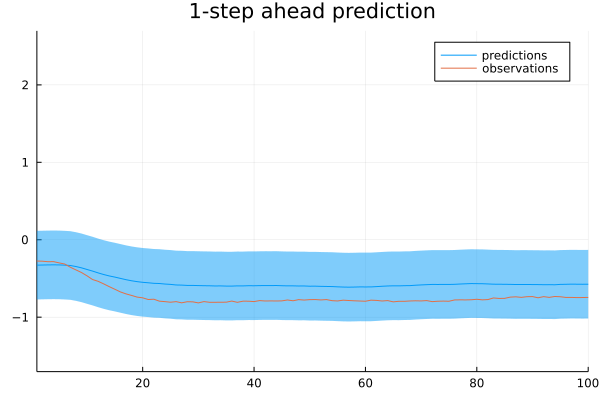

In [474]:
plot(mean.(predictions), ribbon=sqrt.(first.(cov.(predictions))), label="predictions")
plot!(Y_test, xlims=(1, 100), title="1-step ahead prediction", label="observations")

In [475]:
# plot(first.(mean.(h_)), ribbon=sqrt.(first.(cov.(h_))))

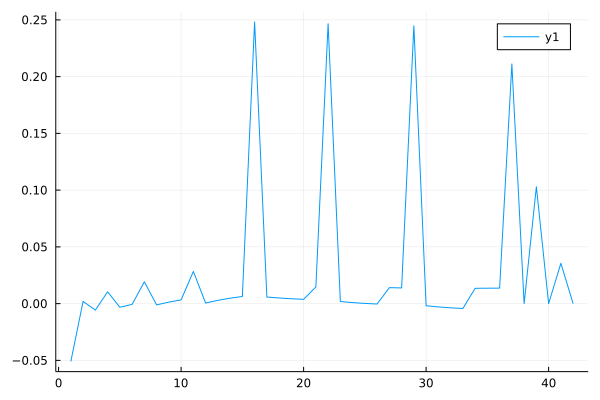

In [476]:
plot(mean(η_prior))

In [477]:
RMSE = sqrt(mean((mean.(predictions) .- Y_test) .^2))

0.21453910192319958

In [478]:
# naive simulation setting

In [479]:
# η_prior = MvNormalMeanPrecision(coefs_mean, 1e5diageye(full_order))
η_prior = η_;

In [480]:
# h_prior = MvNormalMeanPrecision(zeros(4), diageye(4))

In [481]:
# h_prior = h_[end]
# w_prior = w_
# τ_prior = τ_
# η_prior = η_

simulated_X = [X_test[1]]
simulated_Y = [Y_test[1]]
simulated_Y_cov = [1.0]
ProgressMeter.@showprogress for i in 1:length(Y_test)
       _, h_post, θ_post, w_post, η_post, τ_post, z_out, y_out_post = narmax_inference([simulated_Y[i]], [simulated_X[i]], [U_test[i]], h_order=order_h, full_order=full_order,
                                                                                     h_prior=(mean(h_prior), precision(h_prior)),
                                                                                     w_prior=(shape(w_prior), rate(w_prior)), 
                                                                                     η_prior=(mean(η_prior), precision(η_prior)),
                                                                                     τ_prior=(shape(τ_prior), rate(τ_prior)), vmp_its=10, seed=10, progress=false);

    h_prior = h_post[end]
    η_prior = η_post
    τ_prior = τ_post
    w_prior = w_post
    
    push!(simulated_X, [mean.(y_out_post)[1]; simulated_X[i][1:delay_y-1]])
    pred_sim = prediction(h_prior, mean(w_), η_prior, τ_, simulated_X[i], U_test[i], full_order=full_order, h_order=order_h)

    push!(simulated_Y, mean(pred_sim))
    push!(simulated_Y_cov, var(pred_sim))

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


In [482]:
RMSE = sqrt(mean((simulated_Y[2:end] .- Y_test).^2))

0.912553697741082

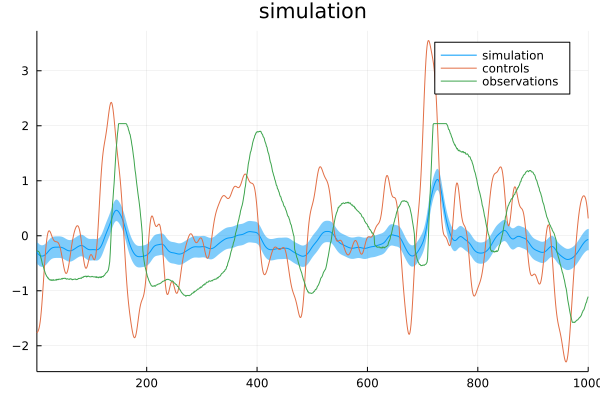

In [484]:
plot(simulated_Y[1:end],  ribbon=simulated_Y_cov[2:end], label="simulation")
plot!(first.(U_test), label="controls")
plot!(Y_test, title="simulation", label="observations", xlims=(1, 1000))

In [411]:
i=4
[U_test[i]; simulations[i-1:-1:i-delay_y]; zeros(4)]

11-element Vector{Float64}:
 -0.580200337952787
 -0.4670002720164626
 -0.11390006634405844
 -0.0020000011649533964
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [413]:
# Posterior predictive
delay_y, delay_u, delay_e = 3, 3, 3
# coefs = [-0.0005020087477669818, -0.19888245332633947, 0.2284249517358315, 0.9900635121105694, 0.4591040743595447]
simulations = zeros(length(Y_test),)
Phi = []
for i in 4:length(Y_test)
    ϕx = ϕ([U_test[i]; simulations[i-1:-1:i-delay_y]; zeros(3)], Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>2, "dc"=>true, "crossTerms"=>true, "noiseCrossTerms"=>false))
    push!(Phi, ϕx)
    simulations[i] = realish'*ϕx
end

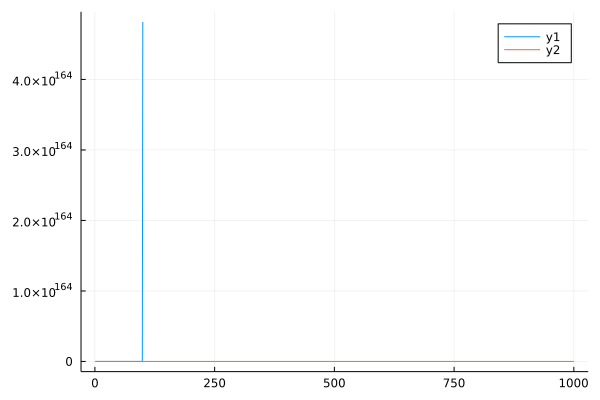

In [414]:
plot(simulations)
plot!(Y_test)

In [415]:
RMSE = sqrt(mean((simulations .- Y_test).^2))

NaN

In [416]:
function debug_pred(h_prior, w_mle, η_posterior, τ_posterior, y_prev, u; full_order, h_order)
    h_out = @call_rule MvNormalMeanCovariance(:out, Marginalisation) (m_μ=MvNormalMeanPrecision(mean(h_prior), precision(h_prior)), q_Σ=PointMass(transition(mean(w_), order_h)))
    ϕ_out = @call_rule NonlinearNode(:out, Marginalisation) (m_in=h_out, meta=NonlinearMeta(phi_, y_prev, u, full_order))
    ar_out = @call_rule AR(:y, Marginalisation) (q_x=ϕ_out, q_θ=η_posterior, q_γ=τ_posterior, meta=ARMeta(Multivariate, full_order, ARsafe()))
    c = zeros(full_order); c[1] = 1.0
    dot_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=ar_out, meta=ReactiveMP.TinyCorrection())
    c = zeros(h_order); c[1] = 1.0
    c_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=h_out, meta=ReactiveMP.TinyCorrection())
    @call_rule typeof(+)(:out, Marginalisation) (m_in1=dot_out, m_in2=c_out)    
end

debug_pred (generic function with 1 method)

In [420]:
# Posterior predictive
# coefs = [-0.0005020087477669818, -0.19888245332633947, 0.2284249517358315, 0.9900635121105694, 0.4591040743595447]
# coefs = mean(η_)
simulations = zeros(length(Y_test),)
η_prior = MvNormalMeanPrecision(realish, diageye(full_order))
η_prior = η_
Φ = []
for i in 4:length(Y_test)
#     ϕx = ϕ([U_test[i]; simulations[i-1:-1:i-delay_y]; [0.0]], Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>1, "dc"=>true, "crossTerms"=>true, "noiseCrossTerms"=>false))
#     ϕ_out =  mean(debug_pred(h_prior, mean(w_), η_prior, τ_, simulations[i-1:-1:i-delay_y], U_test[i], full_order=full_order, h_order=order_h))
    ϕ_out =  mean(debug_pred(h_prior, mean(w_), η_prior, τ_, simulations[i-1:-1:i-delay_y], U_test[i], full_order=full_order, h_order=order_h))
#     push!(Φ, ϕ_out)
    simulations[i] = ϕ_out
#     simulations[i] = mean(prediction(h_prior, mean(w_), η_prior, τ_, simulations[i-1:-1:i-delay_y], U_test[i], full_order=full_order, h_order=order_h))
end

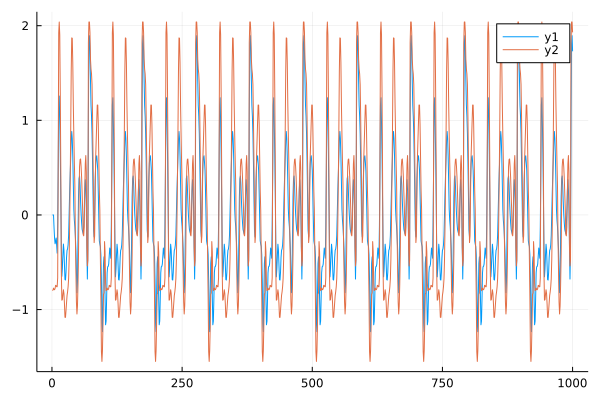

In [421]:
plot(simulations)
plot!(Y_test)

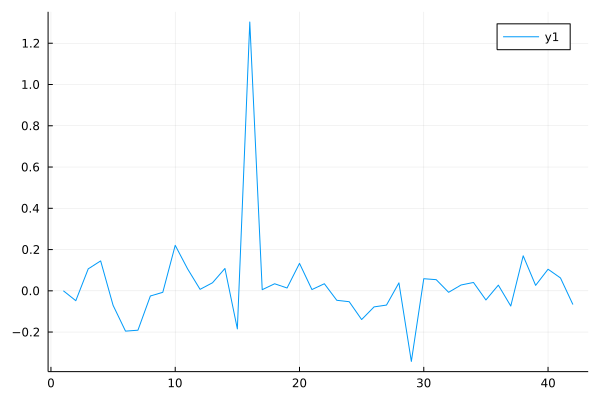

In [149]:
plot(mean(η_prior))